In [5]:
import numpy
import numpy as np
import numpy,scipy,corner
import nestle
import astropy,warnings
from scipy.interpolate import interp1d as interp
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as multi_gauss
#---------------------------------------------------------------------
import Library_GraphTwoDimensionDensityColorMap
#---------------------------------------------------------------------
warnings.simplefilter('ignore')
print ("done importing")

done importing


# Pick a Seed

In [41]:
numpy.random.seed(0)

# (Probability Workbook) Generate some correlated bimodal data

In [67]:
#We need a bimodal gaussian, each of which is very correlated and has almost the same covariance matrix

In [68]:
ABdata1 = numpy.random.multivariate_normal( mean = [1, 1], cov= [[2,2],[5,20]], size = 500 )

In [82]:
ABdata2 = numpy.random.multivariate_normal( mean = [4, 7], cov= [[5,5],[5,20]], size = 500 )

In [83]:
ABAllData = numpy.concatenate( [ABdata1, ABdata2] )
print (ABAllData.shape)

(1000, 2)


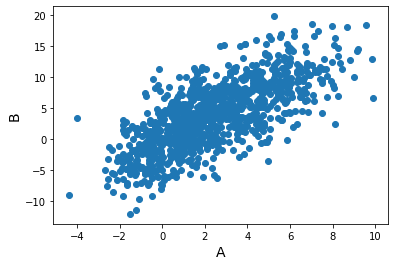

In [84]:
plt.scatter( ABAllData[:,0], ABAllData[:,1] )
plt.xlabel('A', fontsize=14)
plt.ylabel('B', fontsize=14)
plt.show()

DomainMinimumPoint [-10 -10]
DomainMaximumPoint [20 20]
PlugInPointsCount 10000
PointsToPlugInDataset.shape (10000, 2)
PointsToPlugInDataset[0] [-10. -10.]
MaxObservedValue [0.01696702]
MinObservedValue [2.12557331e-204]
Z.shape (100, 100)


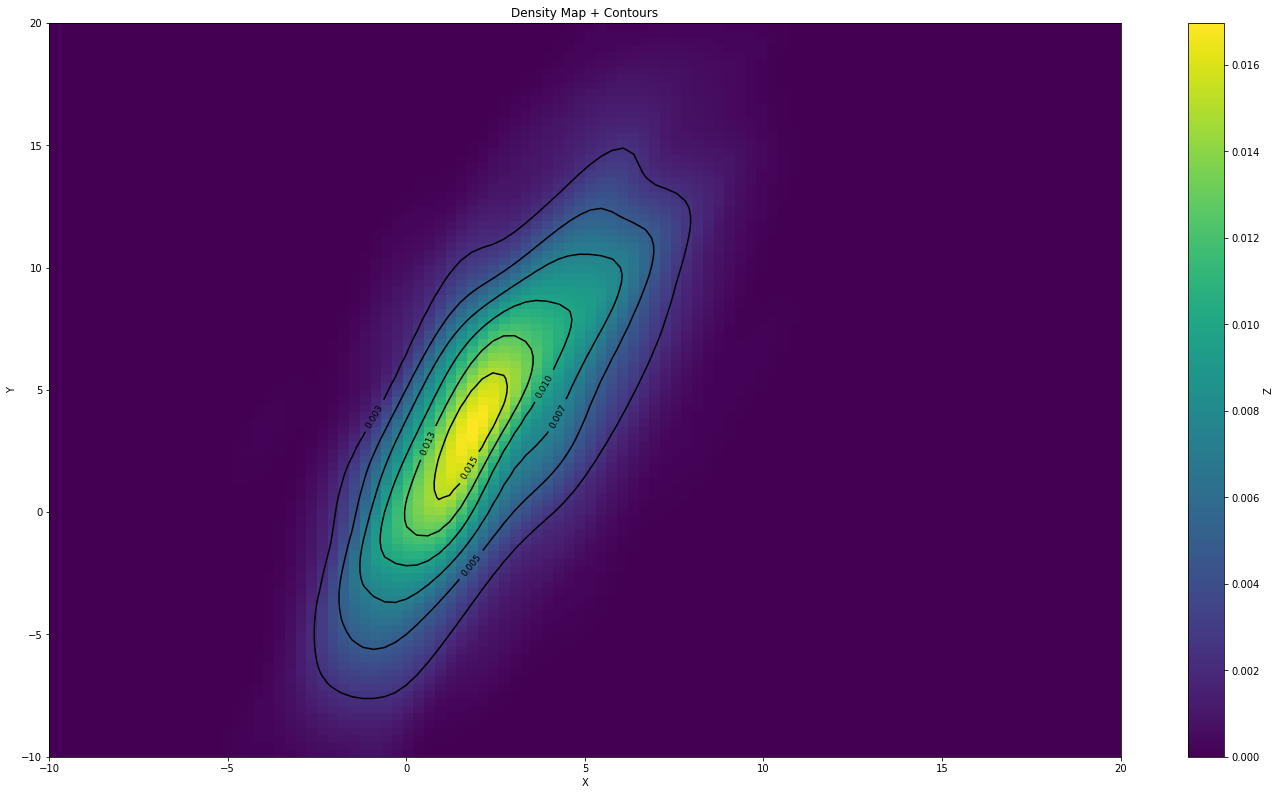

In [85]:
kernel2d = scipy.stats.gaussian_kde( ABAllData.T ) #takes in points sideways....
Library_GraphTwoDimensionDensityColorMap.Main(
    Function = kernel2d.pdf,
    DomainMinimumPoint  = numpy.array([-10, -10]),
    DomainMaximumPoint  = numpy.array([20, 20]),
    ShowContours = True,
    PluginPointCount = 10000,
    PrintExtra = False,
    )

In [86]:
#Write the generated data to a file on the disk of the computer
A = ABAllData[:,0]
B = ABAllData[:,1]
C =  numpy.concatenate( [ numpy.zeros(len(ABdata1)), numpy.ones(len(ABdata2)) ] )
ABdataTable = Table([A,B,C],  names=('A','B','C'))
astropy.io.ascii.write( ABdataTable, "RandomVariable_Generated_Data.astropydat", overwrite = True )

# (Likelihood Workbook) Generate a set of true Datapoints


In [42]:
#(SECRET)

#Set the variables for the 'real' model
v = 50
g = 9.8
def my_model( v, g, t):
    return v*t -.5*g*t**2

In [43]:
#(SECRET)
#Pick some times of which to observe the height
times=np.linspace(.1,10,20) # measurement times

#figure out the heights which are "real" for the given times above
perfect_data=my_model(v,g,times)


datapoint_count = len(times)

# (Likelihood Workbook) Modify the data with height error only

In [44]:
#(SECRET)
#Generate 1D dataset with measurement error
#   By 1D, we mean that we have only error in the height measurement. 
#   We have NO time measurement error   



#Introduce error into the "perfect" data using the experiment error
measurement_uncertainty = 10
errors=[measurement_uncertainty]*datapoint_count

heights=np.random.normal(perfect_data,errors)
my_data_1D=Table([times,heights,errors],
              names=('time','height','error'))

#print( my_data_1D )

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_data_1D, "1D_Generated_Data.astropydat" , overwrite = True )

In [45]:
#(SECRET)
#Generate 1D uncertainty dataset with a model that will not work with
#   a simple chi-square minimization.
#   By 1D, we mean that we have only error in the height measurement. 
#   We have NO time measurement error   .

#Set the variables for our model, and the model itself
bad_v = 50
bad_g = -10
def my_bad_model( v,g, t):
    return v*t -.5*g**2*t**2

#Generate "perfect" data with the bad model.
perfect_bad_data=my_bad_model(bad_v,bad_g,times)
#Introduce error into the "perfect" data using the experiment error
heights_bad=np.random.normal(perfect_bad_data,errors)
my_bad_data_1D=Table([times,heights_bad,errors],
              names=('time','height','error'))

#print( my_data_1D )

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_bad_data_1D, "1D_Generated_Data_ChiProblem.astropydat" , overwrite = True )

# (Likelihood Workbook) Modify the data with time AND height error

In [46]:
#(SECRET)
#Generate 2D uncertainty dataset
#   By 2D, we mean that we have only error in BOTH
#      the height measurement  
#      AND time measurement error 
#   The errors are not mutually exclusive. 
#   The errors can be thought of as DEPENDENT RANDOM VARIABLES

#Define the measurment error function which is something the experimentalist would give us.
covariance_matrix = np.array(
    [
        [.58,   13.35],
        [13.35, 501.77]
    ])
covariance_matrix_list = [covariance_matrix]*datapoint_count

covariance_matrices=[covariance_matrix]*len(perfect_data)

#Use the measurment error function to take the perfect data, and mess it up
times_2d=[]
heights_2d=[]
for i in range(len(perfect_data)):
    t,f=np.random.multivariate_normal(
                    mean=[times[i],perfect_data[i]],
                    cov=covariance_matrix)
    times_2d.append(t)
    heights_2d.append(f)

my_data_2D=Table([times_2d,heights_2d],names=('time','height'))

#Write the generated data to a file on the disk of the computer
astropy.io.ascii.write( my_data_2D, "2D_Generated_Data.astropydat", overwrite = True )





# (Likelihood Workbook) Make plots of data for visual check
## They should not change after fixed seed re-run

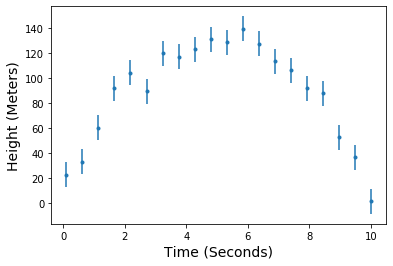

In [47]:
#Plot the 1D-error data
plt.errorbar( my_data_1D['time'], my_data_1D['height'], yerr =  my_data_1D['error'], fmt = ".")
plt.ylabel('Height (Meters)',fontsize=14)
plt.xlabel('Time (Seconds)',fontsize=14)
plt.show()

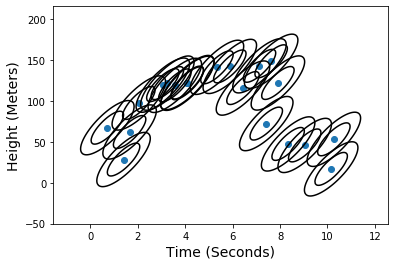

In [48]:
#PLOTS  (YOU DONT NEED THIS CODE)
def generate_experiment_error_function(mu, cov):
    def experiment_error_function(Point):
        x = Point
        return multi_gauss.pdf(x, mu, cov)
    return experiment_error_function

#Plot the data:
plt.scatter(times_2d,heights_2d)
for i in range(len(times_2d)):
    mu = np.array([times_2d[i],heights_2d[i]])
    cov = covariance_matrix
    Function = generate_experiment_error_function(mu, cov)
    xmin=-3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    xmax=3*np.sqrt(covariance_matrix[0][0])+times_2d[i]
    ymin=-3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    ymax=3*np.sqrt(covariance_matrix[1][1])+heights_2d[i]
    X, Y = numpy.mgrid[xmin:xmax:100j, ymin:ymax:100j] #1000 x 1000 -> 1 million points
    PointsToPlugIn = numpy.vstack([X.ravel(), Y.ravel()])
    PointsToPlugInDataset = PointsToPlugIn.T
    PlugInPointsCount = len(PointsToPlugInDataset)
    FunctionResultValuesForGrid = numpy.zeros((PlugInPointsCount))
    k = 0
    while (k < PlugInPointsCount):
        PointToPlugIn = PointsToPlugInDataset[k]
        FunctionValueForPointToPlugIn = Function(PointToPlugIn)
        FunctionResultValuesForGrid[k] = FunctionValueForPointToPlugIn
        k = k + 1
    Z = numpy.reshape(FunctionResultValuesForGrid, X.shape)
    CS = plt.contour(X, Y, Z, 2,
                             colors='k', # negative contours will be dashed by default
                             )
plt.xlabel('Time (Seconds)',fontsize=14)
plt.ylabel('Height (Meters)',fontsize=14)
plt.draw()

